<h1>Predictive Model for Restaurant Recommendation</h1>

<h2>1. Import Libraries and Load Data</h2>

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import re

<h2>2. Data Preprocessing</h2>

Load and Prepare Data

In [5]:
# Import Data
df = pd.read_csv('./data/portsmouth_restaurants_google_maps_data.csv')
df_location = pd.read_csv('./data/portsmouth_restaurants_location.csv')

# Sourced from and extracted from https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/smallareaincomeestimatesformiddlelayersuperoutputareasenglandandwales
df_income_by_area = pd.read_csv('./data/income2020.csv')

# Sourced from https://open-geography-portalx-ons.hub.arcgis.com/datasets/ons::postcode-to-oa-2021-to-lsoa-to-msoa-to-lad-with-2011-classifications-november-2023-best-fit-lookup-in-the-uk/about
df_convert_to_post = pd.read_csv('./data/NSP21CL_NOV23_UK_LU.csv', encoding='latin-1')

C:\Users\JTOSH\AppData\Local\Temp\ipykernel_14228\3236429068.py:9: DtypeWarning: Columns (15,17,18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_convert_to_post = pd.read_csv('./data/NSP21CL_NOV23_UK_LU.csv', encoding='latin-1')


In [ ]:
# Preprocess Data
# Clean price range
def parse_price_range(price):
    if type(price) == str:
      if 'moderate' == price.lower() or 'expensive' == price.lower():
        return np.nan      
      else:
        price = price.replace("£", "")
        bounds = price.split("–")
        return (float(bounds[0]) + float(bounds[1])) / 2 if len(bounds) == 2 else float(bounds[0])
    return np.nan

df['priceRangeAvg'] = df['priceRanges'].apply(parse_price_range)
df.fillna({'priceRangeAvg': df['priceRangeAvg'].median()}, inplace=True)

df.fillna({'phone': '000', 'web': 'no website', 'category': 'restaurant'}, inplace=True)

def remove_non_ascii(address):
    return re.sub(r'[^\x00-\x7F]+', '', address)

# Remove non ascii characters:
df['address'] = df['address'].apply(remove_non_ascii)
df['phone'] = df['phone'].apply(remove_non_ascii)
df['web'] = df['web'].apply(remove_non_ascii)

df.head(5)


,name,rating,ratingCount,priceRanges,category,address,postcode,openingHours,phone,web,serviceInfo,priceRangeAvg
0,Cocked Hat,4.0,2209.0,£10–20,Pub,"Privett Rd, Gosport PO12 3TR",PO12 3TR,NaN,023 9258 3422,greeneking.co.uk,"{""Accessibility"":""Wheelchair-accessible car pa...",15.0
1,Tap & Tandoor,4.7,579.0,NaN,Gastropub,"Gunwharf Rd, Portsmouth PO1 3TJ",PO1 3TJ,NaN,023 9381 3150,tapandtandoor.co.uk,"{""Accessibility"":""Wheelchair-accessible car pa...",15.0
2,Bella Calabria,4.4,919.0,£10–20,Italian restaurant,"45 London Rd, North End, Portsmouth PO2 0BH",PO2 0BH,"{""Sunday"":""12 - 10pm"",""Monday"":""12 - 10pm"",""Tu...",023 9269 4371,bellacalabriaportsmouth.com,"{""Accessibility"":""Wheelchair-accessible entran...",15.0
3,Nice Tin Tin Chinese Restaurant,4.4,456.0,NaN,Chinese restaurant,"28 The Hard, Portsmouth PO1 3DT",PO1 3DT,"{""Sunday"":""12 - 10:30pm"",""Monday"":""12 - 10:30p...",023 9217 4590,nicetintin.co.uk,"{""Accessibility"":""Wheelchair-accessible car pa...",15.0
4,El Greco,4.7,288.0,£20–30,Greek restaurant,"8 Bellevue Terrace, Southsea, Portsmouth, Sout...",PO5 3AT,"{""Sunday"":""1:30 - 10pm"",""Monday"":""Closed"",""Tue...",07594 159161,elgrecoportsmouth.co.uk,"{""Service options"":""Takeaway, Dine-in, Deliver...",25.0


In [ ]:
# df_location.info()
# df_location.describe()

print(f"The number of duplicate restaurants postcode is {df_location.duplicated(subset=['postcode']).sum()}")
df_location.drop_duplicates(subset=['postcode'], inplace=True)
print(f"The number of duplicate restaurants  postcode is {df_location.duplicated(subset=['postcode']).sum()}")
print(f"Missing values in each restaurant location column {df_location.isnull().sum()}")

df_location.drop(columns=['admin_county'], axis=1, inplace=True)

The number of duplicate restaurants postcode is 0
The number of duplicate restaurants  postcode is 0
Missing values in each restaurant location column postcode           0
admin_county      84
admin_district     1
nuts               1
pfa                0
latitude           0
longitude          1
country            1
dtype: int64


In [ ]:
# Merge dataset
restaurants_df = df.merge(df_location, how='left', on='postcode' ) 
print(f"The number of rows in dataset is {restaurants_df.shape[0]}")
print(f"The number of columns in dataset is {restaurants_df.shape[1]}")
# restaurants_df.head()
# restaurants_df.info()

restaurants_df.dropna(subset=['latitude', 'longitude'], inplace=True)
restaurants_df.fillna(method='ffill', inplace=True)
restaurants_df.info()

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(restaurants_df, geometry=gpd.points_from_xy(restaurants_df['longitude'], restaurants_df['latitude']))

The number of rows in dataset is 117
The number of columns in dataset is 18
<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, 0 to 116
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            116 non-null    object 
 1   rating          116 non-null    float64
 2   ratingCount     116 non-null    float64
 3   priceRanges     116 non-null    object 
 4   category        116 non-null    object 
 5   address         116 non-null    object 
 6   postcode        116 non-null    object 
 7   openingHours    114 non-null    object 
 8   phone           116 non-null    object 
 9   web             116 non-null    object 
 10  serviceInfo     116 non-null    object 
 11  priceRangeAvg   116 non-null    float64
 12  admin_district  116 non-null    object 
 13  nuts            116 non-null    object 
 14  pfa             116 non-null    object 
 15  latitude        116 non-null    object 
 16  longitude

C:\Users\JTOSH\AppData\Local\Temp\ipykernel_5016\2212102449.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  restaurants_df.fillna(method='ffill', inplace=True)


In [7]:
# Get for Portsmouth
df_income_by_area = df_income_by_area[df_income_by_area['Local authority name'] == 'Portsmouth']
df_income_by_area
# # Sourced from https://geoportal.statistics.gov.uk/datasets/e7824b1475604212a2325cd373946235/about
# df_convert_to_post = pd.read_csv('./data/NSP21CL_NOV23_UK_LU.csv')

,MSOA code,MSOA name,Local authority code,Local authority name,Region code,Region name,Total annual income (�),Upper confidence limit (�),Lower confidence limit (�),Confidence interval (�)
5119,E02003524,Portsmouth 001,E06000044,Portsmouth,E12000008,South East,"37,300","44,400","31,300","13,100"
5120,E02003525,Portsmouth 002,E06000044,Portsmouth,E12000008,South East,"37,700","44,800","31,700","13,100"
5121,E02003526,Portsmouth 003,E06000044,Portsmouth,E12000008,South East,"53,700","63,500","45,500","18,000"
5122,E02003527,Portsmouth 004,E06000044,Portsmouth,E12000008,South East,"47,800","56,300","40,600","15,700"
5123,E02003529,Portsmouth 006,E06000044,Portsmouth,E12000008,South East,"51,600","61,100","43,600","17,500"
5124,E02003530,Portsmouth 007,E06000044,Portsmouth,E12000008,South East,"44,100","51,900","37,400","14,500"
5125,E02003531,Portsmouth 008,E06000044,Portsmouth,E12000008,South East,"46,800","55,300","39,600","15,700"
5126,E02003532,Portsmouth 009,E06000044,Portsmouth,E12000008,South East,"48,900","57,900","41,300","16,600"
5127,E02003533,Portsmouth 010,E06000044,Portsmouth,E12000008,South East,"43,400","51,700","36,400","15,300"
5128,E02003534,Portsmouth 011,E06000044,Portsmouth,E12000008,South East,"49,300","58,500","41,600","16,900"


<h2>3. Geospatial Analysis</h2>

Compute Similarity Scores

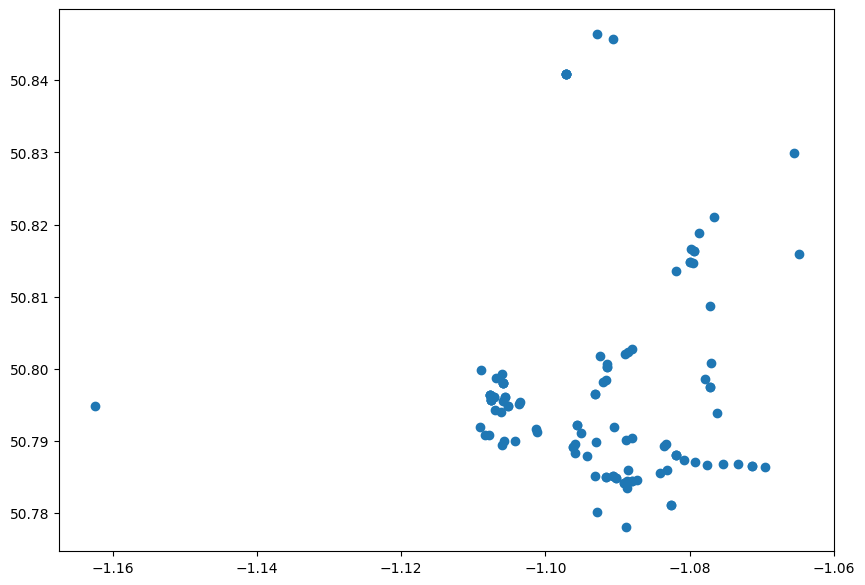

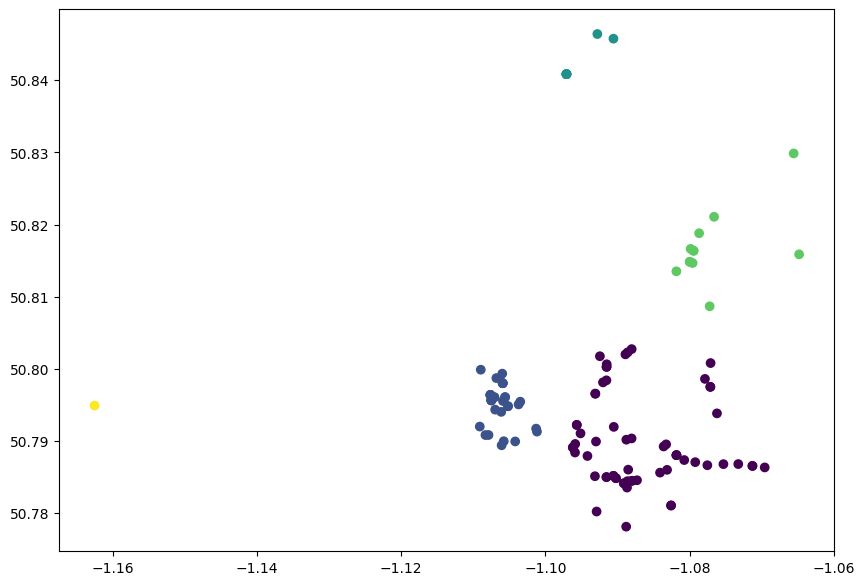

In [ ]:
# Visualize the restaurant locations on a map
gdf.plot(figsize=(10, 8))
plt.show()

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(gdf[['longitude', 'latitude']])
gdf['cluster'] = kmeans.labels_

# Visualize the clusters
gdf.plot(column='cluster', cmap='viridis', figsize=(10, 8))
plt.show()